In [2]:
!pip install torch==2.2.1
!pip install sentence-transformers==2.6.0
!pip install llama-index==0.10.20
!pip install python-dotenv==1.0.1
!pip install llama-index-embeddings-huggingface==0.1.4
!pip install llama-index-readers-web==0.1.9
!pip install youtube_transcript_api==0.6.2
!pip install llama-index-readers-youtube-transcript==0.1.4

  Using cached torch-2.2.1-cp39-cp39-win_amd64.whl.metadata (26 kB)
Using cached torch-2.2.1-cp39-cp39-win_amd64.whl (198.5 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.3.0
    Uninstalling torch-2.3.0:
      Successfully uninstalled torch-2.3.0
  Using cached sentence_transformers-2.6.0-py3-none-any.whl.metadata (11 kB)
  Using cached scikit_learn-1.4.2-cp39-cp39-win_amd64.whl.metadata (11 kB)
  Using cached scipy-1.13.0-cp39-cp39-win_amd64.whl.metadata (60 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached sentence_transformers-2.6.0-py3-none-any.whl (163 kB)
Using cached scikit_learn-1.4.2-cp39-cp39-win_amd64.whl (10.6 MB)
Using cached scipy-1.13.0-cp39-cp39-win_amd64.whl (46.2 MB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
  Using cached llama_index-0.10.20-py3-none-any.whl.metadata (8.8 kB)
  Using cached llama_index_agent_openai-0.1.7-py3-none-any.whl.metadata (644 bytes)
Using cached llama_index-0.10

## Setup API keys

In [2]:
import os
import openai
from dotenv import load_dotenv
from dotenv import load_dotenv, find_dotenv

load_dotenv()
openai.api_key = os.getenv('OPENAI_API_KEY')
assert openai.api_key, 'Please set OPENAI_API_KEY!'

youtube_api_key = os.getenv('YOUTUBE_API_KEY')
assert youtube_api_key, 'Please set YOUTUBE_API_KEY!'

## Some Utility Functions

In [28]:
from llama_index.core import (
    Document,
    SimpleDirectoryReader,
    VectorStoreIndex,
    DocumentSummaryIndex,
    SummaryIndex,
    StorageContext,
    load_index_from_storage,
    get_response_synthesizer
)
from llama_index.readers.youtube_transcript import YoutubeTranscriptReader
from llama_index.core.tools import FunctionTool, QueryEngineTool, ToolMetadata
from llama_index.llms.openai import OpenAI
from llama_index.core.node_parser import SentenceSplitter

def get_youtube_transcript_doc(yt_links:list)->Document:
    return YoutubeTranscriptReader().load_data(ytlinks=yt_links)

def build_vector_index(doc:Document, persist_dir=None)->VectorStoreIndex:
    if persist_dir:
        storage_context = StorageContext.from_defaults(persist_dir=persist_dir)
        index = VectorStoreIndex.load_from_storage(storage_context)
    else:
        index = VectorStoreIndex.from_documents(doc, show_progress=True)
    return index

def build_summary_index(doc:Document, persist_dir=None)->SummaryIndex:
    if persist_dir:
        storage_context = StorageContext.from_defaults(persist_dir=persist_dir)
        index = DocumentSummaryIndex.load_from_storage(storage_context)
    else:
        # from https://docs.llamaindex.ai/en/stable/examples/index_structs/doc_summary/DocSummary/
        index = DocumentSummaryIndex.from_documents(doc, show_progress=True)
        # LLM (gpt-3.5-turbo)
        chatgpt = OpenAI(temperature=0, model="gpt-3.5-turbo")
        splitter = SentenceSplitter(chunk_size=1024)

        # default mode of building the index
        response_synthesizer = get_response_synthesizer(
            response_mode="tree_summarize", use_async=True
        )
        doc_summary_index = DocumentSummaryIndex.from_documents(
            doc,
            llm=chatgpt,
            transformations=[splitter],
            response_synthesizer=response_synthesizer,
            show_progress=True,
        )
    return index

def get_query_engine(index, similarity_top=3):
    return index.as_query_engine(similarity_top_k=similarity_top)

def get_youtube_tool():
    return FunctionTool.from_defaults(fn=get_youtube_transcript_doc)


In [14]:
import nest_asyncio

nest_asyncio.apply()

## Create an example Vector Index from a YouTube Link

In [15]:
# Intro to LLMs, Andrej Karpathy
yt_links = ["https://www.youtube.com/watch?v=zjkBMFhNj_g"]

# AMD at Computex 2024: AMD AI and High-Performance Computing with Dr. Lisa Su
# yt_links = ["https://www.youtube.com/watch?v=MCi8jgALPYA"]

yt_doc = get_youtube_transcript_doc(yt_links)
yt_vector_index = build_vector_index(yt_doc)

yt_engine = get_query_engine(yt_vector_index)
# yt_tool = get_youtube_tool(transcript_doc)

query_engine_tools = [
    QueryEngineTool(
        query_engine=yt_engine,
        metadata=ToolMetadata(
            name="youtube",
            description=(
                "YouTube transcript of Andrej Karpathy's Introduction to LLMs. "
                "Use a detailed plain text question as input to the tool."
            ),
        ),
    ),
]

Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/19 [00:00<?, ?it/s]

Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Summarizing documents:   0%|          | 0/1 [00:00<?, ?it/s]

current doc id: zjkBMFhNj_g


Generating embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Summarizing documents:   0%|          | 0/1 [00:00<?, ?it/s]

current doc id: zjkBMFhNj_g


Generating embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

## Summarize Document

In [19]:
yt_doc = get_youtube_transcript_doc(yt_links)
doc_id = "youtube_doc"
yt_doc[0].doc_id = doc_id
yt_summary_index = build_summary_index(yt_doc)

Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

<string>:3: RuntimeWarning: coroutine 'run_async_tasks.<locals>._gather' was never awaited
<string>:3: RuntimeWarning: coroutine 'Dispatcher.span.<locals>.async_wrapper' was never awaited


Summarizing documents:   0%|          | 0/1 [00:00<?, ?it/s]

current doc id: youtube_doc


Generating embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Summarizing documents:   0%|          | 0/1 [00:00<?, ?it/s]

current doc id: youtube_doc


Generating embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
print(yt_summary_index.get_document_summary(doc_id))

The provided text discusses large language models, their capabilities, challenges, and future directions. It delves into the concept of these models as an emerging operating system orchestrating tools for problem-solving, the distinction between system one and system two thinking, potential self-improvement challenges, and the idea of customization through an "App Store" for language models. Additionally, the text explores various types of attacks on large language models, including jailbreak attacks, prompt injection attacks, and data poisoning or backdoor attacks, along with defenses developed to counter these attacks. Some questions that this text can answer include the scaling laws in large language models, how jailbreak attacks can be performed, security challenges specific to these models, methods for customizing language models for specific tasks, and potential future directions for the development of large language models. It also addresses the workings of prompt injection atta

## Query the Index

In [6]:
query = "What's a neural network?"
response = yt_engine.query(query)
print(response)

The main takeaways are that large language models operate in two modes of thinking - system one for quick, instinctive responses and system two for rational, conscious decision-making. These models are evolving to incorporate tool use, enabling them to perform tasks like data analysis and graph generation. The training process involves pre-training on internet text for knowledge and fine-tuning on Q&A documents for alignment, resulting in assistant models capable of providing helpful responses.


## Create a ReAct Agent

In [7]:
from llama_index.llms.openai import OpenAI
from llama_index.core.agent import ReActAgent

llm = OpenAI(model="gpt-4")
agent = ReActAgent.from_tools(
    query_engine_tools,
    llm=llm,
    verbose=True,
)

## Test Agent

In [8]:
hint = "(use the youtube tool)"
queries = [
    # "Summarize to just the main takeaways.",
    # "What is a LLM according to Andrej Karpathy?",
    # "How does it work?",
    "How do you train ChatGPT?",
    "What's system 1 vs. system 2 thinking?",
    "What were the two main stages of AlphaGo?",
    "What will an LLM OS be able to do in a few years?",
    "How do you jailbreak an LLM?",
    "How do you do prompt injection?",
]

for query in queries:
    print(f"Query: {query}")
    response = agent.chat(f"{query}\n{hint}")
    print("-------------------------------------------------------------")

Query: How do you train ChatGPT?
Thought: The user wants to know how ChatGPT is trained. I can use the YouTube tool to fetch the transcript of Andrej Karpathy's Introduction to LLMs, which might contain information on how ChatGPT is trained.
Action: youtube
Action Input: {'input': 'How is ChatGPT trained?'}
Observation: ChatGPT is trained by utilizing a process that involves human-machine collaboration. This process entails humans providing helpful, truthful, and harmless labeling instructions to guide the training of the model. Additionally, the training process involves leveraging the capabilities of language models to sample answers, allowing humans to select and combine parts of these answers to create the best responses. This collaborative approach helps in efficiently and accurately training ChatGPT.
Thought: I can answer without using any more tools. I'll use the user's language to answer.
Answer: ChatGPT is trained through a process of human-machine collaboration. Humans provid

## Interactive chat

In [9]:
while True:
    user_input = input()
    if not user_input:
        break
    print(f"User: {user_input}")
    response = agent.chat(user_input)
    print(f"Agent: {response}")

## YouTube Interactive API

In [1]:
import os
from dotenv import load_dotenv
from dotenv import load_dotenv, find_dotenv

load_dotenv()
youtube_api_key = os.getenv('YOUTUBE_API_KEY')
assert youtube_api_key

### Fetch and process youtube transcript

In [24]:
from youtube_transcript_api import YouTubeTranscriptApi
import json
import re

def get_video_url(video_id:str):
    return f"https://www.youtube.com/watch?v={video_id}"

def extract_video_id(url):
    patterns = [
        r'(?:https?:\/\/)?(?:www\.)?youtube\.com\/watch\?v=([^&]+)',
        r'(?:https?:\/\/)?(?:www\.)?youtu\.be\/([^?]+)',
        r'(?:https?:\/\/)?(?:www\.)?youtube\.com\/embed\/([^?]+)',
        r'(?:https?:\/\/)?(?:www\.)?youtube\.com\/v\/([^?]+)',
    ]
    
    for pattern in patterns:
        match = re.search(pattern, url)
        if match:
            return match.group(1)
    
    return None

def fetch_transcript(video_id):
    try:
        transcript = YouTubeTranscriptApi.get_transcript(video_id)
        return transcript
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def save_transcript(transcript, output_file):
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(transcript, f, ensure_ascii=False, indent=2)

def print_transcript(transcript):
    for entry in transcript:
        start_time = entry['start']
        duration = entry['duration']
        text = entry['text']
        end_time = start_time + duration
        
        # Format timestamp as HH:MM:SS
        start_formatted = format_timestamp(start_time)
        end_formatted = format_timestamp(end_time)
        
        print(f"[{start_formatted} - {end_formatted}] {text}")

def format_timestamp(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours:02d}:{minutes:02d}:{seconds:02d}"

def save_formatted_transcript(transcript, output_file):
    with open(output_file, 'w', encoding='utf-8') as f:
        for entry in transcript:
            start_time = entry['start']
            duration = entry['duration']
            text = entry['text']
            end_time = start_time + duration
            
            start_formatted = format_timestamp(start_time)
            end_formatted = format_timestamp(end_time)
            
            f.write(f"[{start_formatted} - {end_formatted}] {text}\n")

### Search Youtube

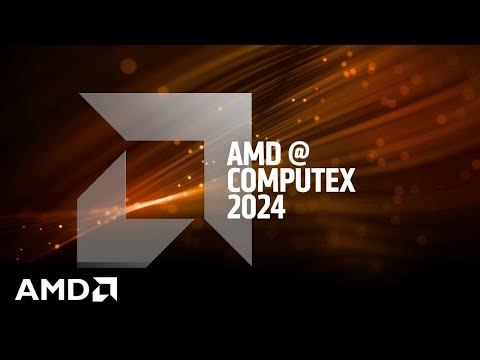

In [22]:
# Import necessary libraries
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from IPython.display import YouTubeVideo, display, HTML

# Replace with your actual API key
YOUTUBE_API_SERVICE_NAME = "youtube"
YOUTUBE_API_VERSION = "v3"

def youtube_search(query, max_results=1):
    youtube = build(YOUTUBE_API_SERVICE_NAME, YOUTUBE_API_VERSION, developerKey=youtube_api_key)

    try:
        search_response = youtube.search().list(
            q=query,
            type="video",
            part="id,snippet",
            maxResults=max_results
        ).execute()

        videos = []

        for search_result in search_response.get("items", []):
            video = {
                "title": search_result["snippet"]["title"],
                "description": search_result["snippet"]["description"],
                "video_id": search_result["id"]["videoId"],
                "publish_time": search_result["snippet"]["publishTime"],
                "channel_title": search_result["snippet"]["channelTitle"]
            }
            videos.append(video)

        return videos

    except HttpError as e:
        print(f"An HTTP error {e.resp.status} occurred:\n{e.content}")
        return None

# Function to display search results
def display_results(results):
    for i, video in enumerate(results, 1):
        display(HTML(f"<h3>{i}. {video['title']}</h3>"))
        display(HTML(f"<p><strong>Channel:</strong> {video['channel_title']}</p>"))
        display(HTML(f"<p><strong>Published:</strong> {video['publish_time']}</p>"))
        display(HTML(f"<p><strong>Description:</strong> {video['description'][:100]}...</p>"))
        display(YouTubeVideo(video['video_id'], width=400, height=300))
        display(HTML("<hr>"))

# Example usage
search_query = "Lisa Su Computex Keynote"
results = youtube_search(search_query)

if results:
    display_results(results)
else:
    print("No results found or an error occurred.")

### Playback YouTube video

In [20]:
import os
import tempfile
import subprocess
from pytube import YouTube
import time

def download_youtube_video(video_id, temp_dir=None):
    video_url = f"https://www.youtube.com/watch?v={video_id}"
    
    try:
        yt = YouTube(video_url)
        stream = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first()

        # Create a temporary directory
        if not temp_dir:
            temp_dir = tempfile.mkdtemp()
            print(f"Temporary directory created: {temp_dir}")

        # Download the video
        print("Downloading video...")
        video_path = stream.download(output_path=temp_dir)
        print(f"Video downloaded to: {video_path}")

    except Exception as e:
        print(f"An error occurred while downloading and trimming: {e}")
        return None
    
    return temp_dir, video_path


def trim_youtube_video(video_path, start_time, end_time, temp_dir=None):
    try:
        if not temp_dir:
            temp_dir = tempfile.mkdtemp()
            print(f"Temporary directory created: {temp_dir}")

        # Trim the video using ffmpeg
        output_path = os.path.join(temp_dir, 'video.mp4')
        duration = end_time - start_time
        ffmpeg_command = f'ffmpeg -i "{video_path}" -ss {start_time} -t {duration} -c copy "{output_path}"'

        print("Trimming video...")
        print(f"FFmpeg command: {ffmpeg_command}")
        result = subprocess.run(ffmpeg_command, shell=True, capture_output=True, text=True)

        if result.returncode != 0:
            print(f"FFmpeg error: {result.stderr}")
            raise Exception("FFmpeg failed to trim the video")

        print(f"Trimmed video saved to: {output_path}")

        if not os.path.exists(output_path):
            raise FileNotFoundError(f"Trimmed video file not found: {output_path}")

        return temp_dir, output_path

    except Exception as e:
        print(f"An error occurred while downloading and trimming: {e}")
        return None, None


def play_youtube_video(video_path, duration):
    try:
        # Convert to absolute path
        abs_video_path = os.path.abspath(video_path)
        print(f"Absolute video path: {abs_video_path}")

        if not os.path.exists(abs_video_path):
            raise FileNotFoundError(f"Video file not found: {abs_video_path}")

        print(f"Attempting to play video: {abs_video_path}")

        # Play the trimmed video with the default player
        if os.name == 'nt':  # For Windows
            print("Using subprocess method...")
            subprocess.Popen(['start', '', abs_video_path], shell=True)
        else:
            raise NotImplementedError("This script currently supports Windows only")

        print("Default player command executed.")

        # Wait for the duration of the video
        print(f"Waiting for {duration} seconds...")
        time.sleep(duration + 2)  # Add a small buffer

        print("Playback duration completed.")

    except Exception as e:
        print(f"An error occurred while playing: {e}")

    print("Function play_youtube_video completed.")

In [1]:
import os
import tempfile
import subprocess

def trim_and_stitch_youtube_video(video_path, time_segments, output_path, temp_dir=None):
    try:
        assert os.path.isfile(file_path), f"ERROR: {video_path} doesn't exist"

        if not temp_dir:
            temp_dir = tempfile.mkdtemp()
            print(f"Temporary directory created: {temp_dir}")

        # List to store paths of trimmed segments
        trimmed_segments = []

        # Trim each segment
        for i, (start_time, end_time) in enumerate(time_segments):
            segment_path = os.path.join(temp_dir, f'segment_{i}.mp4')
            duration = end_time - start_time
            ffmpeg_command = f'ffmpeg -i "{video_path}" -ss {start_time} -t {duration} -c copy "{segment_path}"'

            print(f"Trimming segment {i+1}/{len(time_segments)}...")
            print(f"FFmpeg command: {ffmpeg_command}")
            result = subprocess.run(ffmpeg_command, shell=True, capture_output=True, text=True)

            if result.returncode != 0:
                print(f"FFmpeg error: {result.stderr}")
                raise Exception(f"FFmpeg failed to trim segment {i+1}")

            trimmed_segments.append(segment_path)

        # Create a file list for concatenation
        list_file_path = os.path.join(temp_dir, 'file_list.txt')
        with open(list_file_path, 'w') as list_file:
            for segment in trimmed_segments:
                list_file.write(f"file '{segment}'\n")

        # Concatenate all segments
        concat_command = f'ffmpeg -f concat -safe 0 -i "{list_file_path}" -c copy "{output_path}" -y'
        print("Concatenating segments...")
        print(f"FFmpeg command: {concat_command}")
        result = subprocess.run(concat_command, shell=True, capture_output=True, text=True)

        if result.returncode != 0:
            print(f"FFmpeg error: {result.stderr}")
            raise Exception("FFmpeg failed to concatenate the segments")

        print(f"Final video saved to: {output_path}")

        if not os.path.exists(output_path):
            raise FileNotFoundError(f"Final video file not found: {output_path}")

        return temp_dir, output_path

    except Exception as e:
        print(f"An error occurred while trimming and stitching: {e}")
        return None, None

# Example usage:
video_path = "path/to/your/video.mp4"
time_segments = [(10, 20), (30, 40), (50, 60)]  # List of (start_time, end_time) tuples
output_path = "path/to/output/final_video.mp4"

temp_dir, final_video_path = trim_and_stitch_youtube_video(video_path, time_segments, output_path)

if temp_dir and final_video_path:
    print("Video processing completed successfully!")
    # Don't forget to clean up the temp_dir when you're done
else:
    print("Video processing failed.")

Temporary directory created: C:\Users\kovtchar\AppData\Local\Temp\tmp62xsxhhv
Trimming segment 1/3...
FFmpeg command: ffmpeg -i "path/to/your/video.mp4" -ss 10 -t 10 -c copy "C:\Users\kovtchar\AppData\Local\Temp\tmp62xsxhhv\segment_0.mp4"
FFmpeg error: ffmpeg version 7.0.1-essentials_build-www.gyan.dev Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 13.2.0 (Rev5, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-bzlib --enable-lzma --enable-zlib --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-sdl2 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libaom --enable-libopenjpeg --enable-libvpx --enable-mediafoundation --enable-libass --enable-libfreetype --enable-libfribidi --enable-libharfbuzz --enable-libvidstab --enable-libvmaf --enable-libzimg --enabl

In [21]:
# AMD at Computex 2024: AMD AI and High-Performance Computing with Dr. Lisa Su
youtube_url = 'https://www.youtube.com/watch?v=MCi8jgALPYA'

start_time = 45  # Start time in seconds
end_time = 67    # End time in seconds

temp_dir, video_path = download_youtube_video(youtube_url, './')
temp_dir, video_path = trim_youtube_video(video_path, start_time, end_time, './')
# video_path = "C:\\Users\\kovtchar\\Work\\gaia\\notebooks\\video.mp4"
play_youtube_video(video_path, 10)

Video downloaded to: c:\Users\kovtchar\Work\gaia\notebooks\./AMD at Computex 2024 AMD AI and High-Performance Computing with Dr Lisa Su.mp4
Trimming video...
FFmpeg command: ffmpeg -i "c:\Users\kovtchar\Work\gaia\notebooks\./AMD at Computex 2024 AMD AI and High-Performance Computing with Dr Lisa Su.mp4" -ss 45 -t 22 -c copy "./video.mp4"


In [7]:

# AMD at Computex 2024: AMD AI and High-Performance Computing with Dr. Lisa Su
youtube_url = 'https://www.youtube.com/watch?v=MCi8jgALPYA'

start_time = 45  # Start time in seconds
end_time = 67    # End time in seconds

video_id = extract_video_id(youtube_url)

if video_id:
    print(f"Extracted Video ID: {video_id}")
    transcript = fetch_transcript(video_id)

    if transcript:
        # Save the structured transcript (with timestamps)
        save_transcript(transcript, 'transcript_structured.json')
        save_formatted_transcript(transcript, 'transcript_formatted.txt')
        print_transcript(transcript)

        temp_dir, video_path = download_youtube_segment(video_id, start_time, end_time)
        if temp_dir and video_path:
            try:
                play_video_segment(video_path, end_time - start_time)
            finally:
                # Clean up: remove the temporary directory and its contents
                print(f"Cleaning up temporary directory: {temp_dir}")
                for file in os.listdir(temp_dir):
                    os.remove(os.path.join(temp_dir, file))
                os.rmdir(temp_dir)
        else:
            print("Failed to download and trim the video segment.")
                play_youtube_segment(video_id, start_time, end_time)
    else:
        print("Could not extract a valid YouTube video ID from the provided URL.")


Extracted Video ID: MCi8jgALPYA
[00:00:36 - 00:00:41] We will now proceed to the AMD opening keynote speech.
[00:00:41 - 00:00:45] TAITRA chairman James Huang will help us introduce our keynote speaker.
[00:00:45 - 00:00:47] Please once again welcome James to the stage.
[00:00:57 - 00:01:00] Now the moment you have been waiting for.
[00:01:00 - 00:01:08] As chair and CEO of AMD, Dr Lisa Su has led a company's transformation into a powerhouse
[00:01:08 - 00:01:11] of high performance computing.
[00:01:11 - 00:01:17] Under her visionary leadership, AMD has achieved remarkable success.
[00:01:17 - 00:01:27] Dr Su was recently named the 2024 chief executive of the year by chief executive magazine.
[00:01:27 - 00:01:34] Recognized for her role in one of the most spectacular achievements in technology sector.
[00:01:34 - 00:01:39] Dr Su's influence extends beyond AMD.
[00:01:39 - 00:01:46] She has been a key advocate for the integration of AI across industries.
[00:01:46 - 00:01:49] Emphasiz

KeyboardInterrupt: 

In [ ]:
play_youtube_segment(video_id, start_time, end_time)

Temporary directory created: C:\Users\kovtchar\AppData\Local\Temp\tmp6n9ty6j7


In [9]:
from websocket import create_connection
from websocket._exceptions import WebSocketTimeoutException
from aiohttp import web

def prompt_llm_server(prompt):

    # Create socket to talk to LLM server
    uri = "ws://localhost:8000/ws"
    llm_server_websocket = create_connection(uri)

    # Send prompt to LLM server
    # print(f"Sending prompt to LLM server:\n{prompt}")
    llm_server_websocket.send(prompt)

    # Listen to LLM server until we receive </s> or no new
    # tokens have been received in a while
    while True:
        try:
            token = llm_server_websocket.recv()

            # Set timeout after first token:
            llm_server_websocket.sock.settimeout(5)

            if token:
                if "</s>" in token:
                    token = token.replace("</s>", "")
                yield token
        except WebSocketTimeoutException:
            break

    if llm_server_websocket.connected:
        llm_server_websocket.close()

def prompt_llm(query):
    response = ""
    new_card = True
    prompt = f"{llm_system_prompt}\nUser: {query} [/INST]\nAssistant: "
    # print(prompt)
    for token in prompt_llm_server(prompt=prompt):

        # Stream token to UI
        # self.stream_to_ui(token, new_card=new_card)
        new_card = False

        response += token
        print(token, end="", flush=True)
    return response


import json
import re

def extract_json_data(input_string):
    # Find the JSON-formatted part of the string
    json_match = re.search(r'\{.*?\}', input_string)
    
    if json_match:
        json_str = json_match.group()
        try:
            # Parse the JSON string
            json_data = json.loads(json_str)
            
            # Extract the key and value
            key, value = next(iter(json_data.items()))
            
            return key, value
        except json.JSONDecodeError:
            return None, None
    else:
        return None, None

In [20]:

llm_states = [
    ("Index is currently not built and is empty.\n"
    "You do not have any access to the information from YouTube\n"
    "You need to perform youtube search using a tool."),
    ("Index is currently built and is not empty.\n"
    "You can now use the query engine to fetch information about the video\n")
]
llm_state = 0

llm_system_prompt = (
    "[INST] <<SYS>>\n"
    "You are a YouTube-focused assistant called Clipy that helps user with YouTube by calling function tools.\n"
    "You are helpful by providing the necessary json-formatted queries in the form of {\"tool\" : \"query\"}:\n"
    "Do not include the results from the tools.\n"
    "In order to build the index, you have to first search YouTube.\n"
    "You only have ability to call the tools below, do not assume you have access to the output from the tools.\n"
    "1. youtube_search(query)\n"
    "2. build_vector_index(video_url)\n"
    "3. query_vector_index(query)\n"
    "\n"
    "Your tasks:\n"
    "2. Output a json that will be used in an external search tool for YouTube videos\n"
    "3. Call tool that can build an index from a video.\n"
    "1. Chat about YouTube content once index is built\n"
    "4. Answer questions from user using the index\n"
    "\n"
    "Guidelines:\n"
    "- Answer a question given in a natural human-like manner.\n"
    "- Think step-by-step when answering questions.\n"
    "- When introducing yourself, keep it to just a single sentence, for example:\n"
    "\"Assistant: Hi, I can help you find information you're looking for on YouTube. Just ask me about any topic!\"\n"
    "- If no index exists, search YouTube and offer to build one\n"
    "- If an index does exist, use the query engine to answer questions.\n"
    "- If unsure, offer to search for more videos\n"
    "- Keep your answers short, concise and helpful\n"
    "- Search_query should be the subject of what the user is looking for, not a youtube link.\n"
    "- Do NOT provide search results, those are being provided by the external tools.\n"
    "- You can only provide the json formatted output to call the tools, you do not have access to the tools directly."
    "Current state of index:\n"
    f"{llm_states[llm_state]}\n"
    "\n"
    "When using a tool, end your response with only the tool function call. Do not answer search results."
    "Always use the most relevant tool for each task.\n"
    "When needing to use a tool, your response should be formatted, here is an example script:\n"
    "User: What kind of philantropy did Mr. Beast do?"
    "Assistant: To answer your question, I first need to search YouTube for the answer. Calling the following tool: {\"youtube_search\" : \"Mr Beast philantropy\"} </s>\n"
    "<</SYS>>\n\n"
)
    # "{'build_vector_index' : video_url}\n"
    # "{'query_vector_index' : query}\n"

# this system prompt has been verified to work with llama v2 7b 4bit on NPU.
query_engine_system_prompt = (
    "[INST] <<SYS>>\n"
    "{context_str}\n\n"
    "Think step-by-step to answer the query in a crisp, short and concise manner based on the information provided.\n"
    "If the answer does not exist in the given information, simply answer 'I don't know!'\n"
    "Do not mention or refer to the context or information provided in your response.\n"
    "Answer directly without any preamble or explanatory phrases about the source of your information.\n"
    "<</SYS>>\n\n"
    "{query_str} [/INST]\n"
)

# prompt = "What did Lisa Su talk about in the Computex Keynote in 2024?"
# prompt_llm(prompt)

In [25]:

prompt = "What did Lisa Su talk about in the Computex Keynote in 2024?"
# response = prompt_llm(prompt)

key, value = extract_json_data(response)
print(f"Key: {key}")
print(f"Value: {value}")

if key == "youtube_search":
    print(f"Performing YouTube search with the following query: {value}")
    result = youtube_search(value, max_results=1)
    print(f"Found the following result:")
    print(f"Title: {result[0]['title']}")
    print(f"Description: {result[0]['description']}")
    print(f"Published: {result[0]['publish_time']}")

    print(f"Fetching transcript from {result[0]}.")
    video_id = result[0]['video_id']
    yt_links = [get_video_url(video_id)]
    yt_doc = get_youtube_transcript_doc(yt_links)
    doc_id = result[0]['title']
    yt_doc[0].doc_id = doc_id

    print(f"Building index...")
    yt_index = build_vector_index(yt_doc)

    print(f"Done! Building query engine...")
    yt_engine = get_query_engine(yt_index)

    print("All done!")
    print("Index and query engine is now ready to be used on your PC. Feel free to ask any questions about the video!")

Key: youtube_search
Value: Lisa Su Computex Keynote 2024
Performing YouTube search with the following query: Lisa Su Computex Keynote 2024
Found the following result:
Title: AMD at Computex 2024: AMD AI and High-Performance Computing with Dr. Lisa Su
Description: The Future of High-Performance Computing in the AI Era Join us as Dr. Lisa Su delivers the Computex 2024 opening keynote and ...
Published: 2024-06-03T03:12:08Z
Fetching transcript from {'title': 'AMD at Computex 2024: AMD AI and High-Performance Computing with Dr. Lisa Su', 'description': 'The Future of High-Performance Computing in the AI Era Join us as Dr. Lisa Su delivers the Computex 2024 opening keynote and ...', 'video_id': 'MCi8jgALPYA', 'publish_time': '2024-06-03T03:12:08Z', 'channel_title': 'AMD'}.


NameError: name 'get_youtube_transcript_doc' is not defined